In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uas-rfm-ulfa/UAS_RFM.csv
/kaggle/input/rfm-terbaru/UAS_RFM.csv


In [7]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
data = pd.read_csv("../input/rfm-terbaru/UAS_RFM.csv")
data

,CardID,TrxDate,Amount
0,1000152,1/11/2021,873623
1,1000158,6/12/2021,473166
2,1000156,2/17/2021,662108
3,1000115,1/6/2021,513694
4,1000164,3/12/2021,516021
...,...,...,...
194,1000113,1/21/2021,319878
195,1000166,3/28/2021,426291
196,1000132,2/12/2021,798910
197,1000121,3/7/2021,502892


In [9]:
data_missing_value = data.isnull().sum().reset_index()
data_missing_value

,index,0
0,CardID,0
1,TrxDate,0
2,Amount,0


In [10]:
data.duplicated().sum()

0

In [11]:
data=data.drop_duplicates()

In [12]:
data.duplicated().sum()

0

In [13]:
filtered_data=data[['CardID','TrxDate']].drop_duplicates()

<AxesSubplot:>

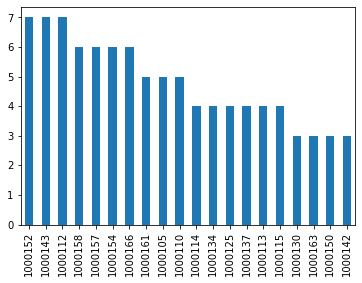

In [14]:
filtered_data.CardID.value_counts()[:20].plot(kind='bar')

<AxesSubplot:>

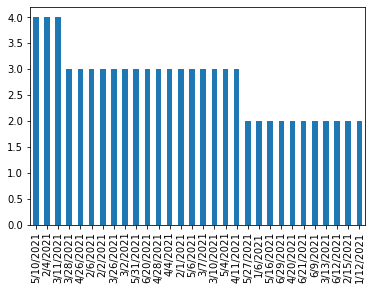

In [15]:
filtered_data.TrxDate.value_counts()[:30].plot(kind='bar')

In [16]:
data['TrxDate']=pd.to_datetime(data['TrxDate'])

In [17]:
data['TrxDate']=pd.to_datetime(data['TrxDate'])

In [18]:
last_date=data['TrxDate'].max()
last_date

Timestamp('2021-06-29 00:00:00')

In [19]:
recency=data.groupby('CardID').agg({'TrxDate': 'max'}).reset_index()
recency.columns=['CardID','last_trans']
recency['recency']=last_date-recency['last_trans']
recency=recency.drop(['last_trans'],axis=1)

recency['recency'] = pd.DataFrame(recency['recency'].astype('timedelta64[D]'))

recency

,CardID,recency
0,1000101,69.0
1,1000102,79.0
2,1000103,9.0
3,1000104,29.0
4,1000105,18.0
...,...,...
66,1000169,126.0
67,1000170,18.0
68,1000171,141.0
69,1000172,33.0


In [20]:
frequency=data.groupby('CardID').agg({'Amount':'count'}).reset_index()
frequency.columns=['CardID','frequency']
frequency

,CardID,frequency
0,1000101,1
1,1000102,3
2,1000103,1
3,1000104,2
4,1000105,5
...,...,...
66,1000169,1
67,1000170,2
68,1000171,1
69,1000172,3


In [21]:
monetary=data.groupby('CardID').agg({'TrxDate': 'count'}).reset_index()
monetary.columns=['CardID','monetary']
monetary

,CardID,monetary
0,1000101,1
1,1000102,3
2,1000103,1
3,1000104,2
4,1000105,5
...,...,...
66,1000169,1
67,1000170,2
68,1000171,1
69,1000172,3


In [22]:
RFM=recency.merge(frequency,
                 on='CardID')
RFM=RFM.merge(monetary,
             on='CardID')
RFM

,CardID,recency,frequency,monetary
0,1000101,69.0,1,1
1,1000102,79.0,3,3
2,1000103,9.0,1,1
3,1000104,29.0,2,2
4,1000105,18.0,5,5
...,...,...,...,...
66,1000169,126.0,1,1
67,1000170,18.0,2,2
68,1000171,141.0,1,1
69,1000172,33.0,3,3


In [23]:
X=RFM[['recency','frequency','monetary']]

from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X)
RFM_std = pd.DataFrame(data = X_std, columns = ['recency','frequency','monetary'])
RFM_std.describe()

,recency,frequency,monetary
count,7.100000e+01,7.100000e+01,7.100000e+01
mean,1.563694e-18,1.344777e-16,1.344777e-16
std,1.007118e+00,1.007118e+00,1.007118e+00
min,-1.271833e+00,-1.134655e+00,-1.134655e+00
25%,-8.512142e-01,-5.052763e-01,-5.052763e-01
50%,-2.977691e-01,1.241029e-01,1.241029e-01
75%,6.320188e-01,1.241029e-01,1.241029e-01
max,2.624421e+00,2.641620e+00,2.641620e+00


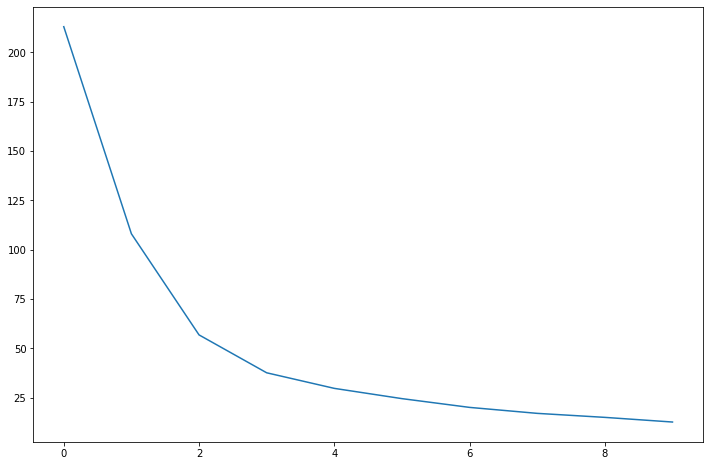

In [24]:
from sklearn.cluster import KMeans
inertia = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
  kmeans.fit(RFM_std.values)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(inertia)

In [25]:
coba= data.groupby('CardID').agg({'TrxDate': lambda date: (last_date - date.max()).days,
                                        'CardID': lambda num: len(num),
                                        'Amount': lambda price: price.sum()})

In [26]:
coba.columns

Index(['TrxDate', 'CardID', 'Amount'], dtype='object')

In [27]:
coba.columns=['monetary','frequency','recency']

In [28]:
coba['recency'] = coba['recency'].astype(int)

In [29]:
coba.head()

,monetary,frequency,recency
CardID,,,
1000101,69,1,954416
1000102,79,3,1938569
1000103,9,1,363278
1000104,29,2,1162662
1000105,18,5,2901381


In [30]:
coba['r_quartile'] = pd.cut(coba['recency'], bins=[0,1,2,5,coba['recency'].max()], labels=['1','2','3','4'])
coba['m_quartile'] = pd.cut(coba['monetary'], bins=[0,1,2,5,coba['monetary'].max()], labels=['4','3','2','1'])
coba['f_quartile'] = pd.cut(coba['frequency'], bins=[0,1,2,5,coba['frequency'].max()], labels=['4','3','2','1'])

In [31]:
coba.head()

,monetary,frequency,recency,r_quartile,m_quartile,f_quartile
CardID,,,,,,
1000101,69,1,954416,4,1,4
1000102,79,3,1938569,4,1,2
1000103,9,1,363278,4,1,4
1000104,29,2,1162662,4,1,3
1000105,18,5,2901381,4,1,2


In [32]:
coba['RFM_Score'] = coba.r_quartile.astype(str)+ coba.f_quartile.astype(str) + coba.m_quartile.astype(str)
coba.head()

,monetary,frequency,recency,r_quartile,m_quartile,f_quartile,RFM_Score
CardID,,,,,,,
1000101,69,1,954416,4,1,4,441
1000102,79,3,1938569,4,1,2,421
1000103,9,1,363278,4,1,4,441
1000104,29,2,1162662,4,1,3,431
1000105,18,5,2901381,4,1,2,421


In [33]:
#No. 1b Filter out Top/Best bank dan rekomendasi
coba[coba['RFM_Score']=='421'].sort_values('monetary', ascending=False).head()

,monetary,frequency,recency,r_quartile,m_quartile,f_quartile,RFM_Score
CardID,,,,,,,
1000141,145,3,1544629,4,1,2,421
1000114,114,4,2548198,4,1,2,421
1000124,110,3,1940175,4,1,2,421
1000107,86,3,1144619,4,1,2,421
1000102,79,3,1938569,4,1,2,421
